# **Research Notebook 03: Baseline Model (Logistic Regression with Hyperparameter Tuning)**

**Objective:** To build, train and evaluate our baseline model (Logistic Regression with TF-IDF) on the *Rigorously Cleaned* dataset to establish a true, non-leaky benchmark.

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import time

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define File Paths

base_path = '/content/drive/MyDrive/Research/'
datasets_path = f'{base_path}datasets/'
models_path = f'{base_path}models/'

train_path = f'{datasets_path}train_dataset_clean.csv'
test_path = f'{datasets_path}test_dataset_clean.csv'

model_save_path = f'{models_path}baseline_model_clean.pkl'

In [ ]:
# Load Datasets

print("--- Baseline Model Development ---")

print("\nLoading datasets...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop any potential NaN rows
# We use the column we prepared for this model: 'cleaned_text_tfidf'
train_df = train_df.dropna(subset=['cleaned_text_tfidf'])
test_df = test_df.dropna(subset=['cleaned_text_tfidf'])

print(f"Training set loaded: {len(train_df)} articles")
print(f"Testing set loaded: {len(test_df)} articles")

--- Baseline Model Development ---

Loading datasets...
Training set loaded: 9024 articles
Testing set loaded: 2256 articles


In [ ]:
# Prepare Data for Modeling

print("Prepare Data for Modeling...")

# X contains the features (our text)
# We use the 'cleaned_text_tfidf' column
X_train = train_df['cleaned_text_tfidf']
X_test = test_df['cleaned_text_tfidf']

# y contains the target labels
y_train = train_df['label']
y_test = test_df['label']

print("\nData prepared for modeling.")

Prepare Data for Modeling...

Data prepared for modeling.


In [ ]:
# Create the Pipeline

print("Creating a machine learning pipeline...")
# A Pipeline chains our steps together.
# 1. 'tfidf': Run the TF-IDF Vectorizer
# 2. 'clf': Run the Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=101, solver='liblinear'))
])

print("\nCreated a machine learning piepline.")

Creating a machine learning pipeline...

Created a machine learning piepline.


In [ ]:
# Define Parameter Grid for GridSearchCV

print("Defining the parameter grid for tuning...")

parameters = {
    'tfidf__max_features': [5000, 7500, 10000],  # Test 3 different vocab sizes
    'tfidf__ngram_range': [(1, 1), (1, 2)],   # Test single words vs. two-word phrases
    'clf__penalty': ['l1', 'l2'],             # Test L1 vs L2 penalty
    'clf__C': [0.1, 1.0, 10.0]                 # Test different regularization strengths
}

print("\nCreated parameter grid for tuning.")

Defining the parameter grid for tuning...

Created parameter grid for tuning.


In [ ]:
# Run GridSearchCV

print("Starting GridSearchCV...")

# Define our Cross-Validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

start_time = time.time()
grid_search = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGridSearchCV finished in {(end_time - start_time):.2f} seconds.")

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GridSearchCV finished in 1307.84 seconds.


In [ ]:
# Show Best Parameters

print("Analyzing tuning results...")
print(f"\nBest cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

Analyzing tuning results...

Best cross-validation score (Accuracy): 0.9744
Best parameters found:
{'clf__C': 10.0, 'clf__penalty': 'l2', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [ ]:
# Evaluate the Best Model on the Test Set

print("Evaluating the best model on the unseen test set...")
y_pred = grid_search.predict(X_test)

# Create a new DataFrame to see the results
results_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred
})

# Print the first 10 results
print("\n--- Comparison of True vs. Predicted Labels ---\n")
results_df.head(10)

Evaluating the best model on the unseen test set...

--- Comparison of True vs. Predicted Labels ---



,text,true_label,predicted_label
0,joe piscopo is hysterical he was on with neil ...,fake,fake
1,the united states on monday described as troub...,real,real
2,staff at the u s environmental protection agen...,real,real
3,this announcement seems to indicate that the o...,fake,fake
4,members of the democratic party s liberal wing...,real,real
5,donald trump on tuesday declined to endorse tw...,real,real
6,huma abedin is hillary s bad cop and is expose...,fake,fake
7,this woman has no shame muslim activist linda ...,fake,fake
8,maine governor paul lepage calls out a liberal...,fake,fake
9,the man answering a volunteer s knock on the d...,real,real


In [ ]:
# --- Key Performance Metrics ---

# We need probabilities for the ROC AUC score
# We also need to map our text labels to 0s and 1s for the ROC functions
y_test_numeric = y_test.map({'fake': 0, 'real': 1})
y_pred_probs = grid_search.predict_proba(X_test)[:, 1] # Probability of 'real'

# Calculate main scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc_score = roc_auc_score(y_test_numeric, y_pred_probs)

print(f"--- Final Model Accuracy:   {accuracy * 100:.2f}%")
print(f"--- Final Model Precision (Macro): {precision * 100:.2f}%")
print(f"--- Final Model Recall (Macro):    {recall * 100:.2f}%")
print(f"--- Final Model F1-Score (Macro):  {f1 * 100:.2f}%")
print(f"--- Final Model ROC AUC Score:     {auc_score * 100:.2f}%")

--- Final Model Accuracy:   97.43%
--- Final Model Precision (Macro): 97.43%
--- Final Model Recall (Macro):    97.43%
--- Final Model F1-Score (Macro):  97.43%
--- Final Model ROC AUC Score:     99.68%


In [ ]:
# Print the detailed classification report

print("--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['fake', 'real']))

--- Detailed Classification Report ---
              precision    recall  f1-score   support

        fake       0.98      0.97      0.97      1128
        real       0.97      0.98      0.97      1128

    accuracy                           0.97      2256
   macro avg       0.97      0.97      0.97      2256
weighted avg       0.97      0.97      0.97      2256



Generating Confusion Matrix...



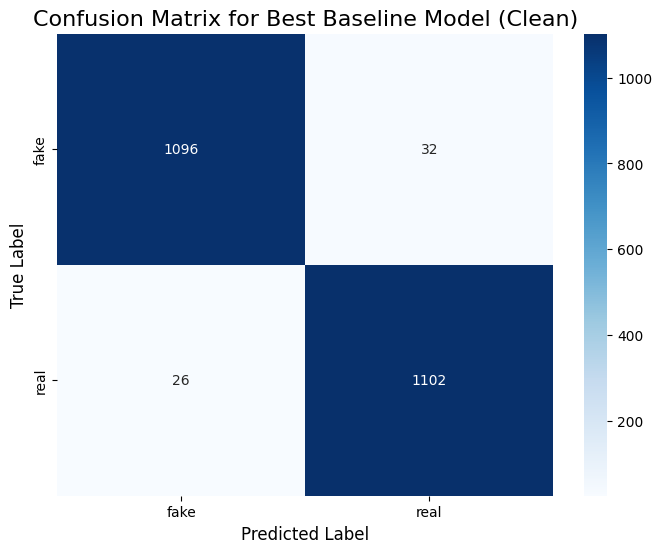

In [ ]:
# Visualize the Confusion Matrix

print("Generating Confusion Matrix...\n")
cm = confusion_matrix(y_test, y_pred)
labels = ['fake', 'real']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Best Baseline Model (Clean)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

Generating ROC AUC Curve...



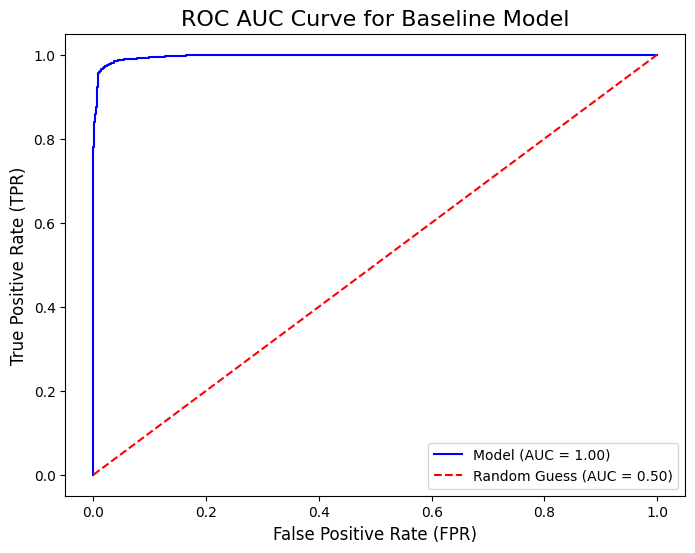

In [ ]:
# Visualize the ROC AUC Curve

print("Generating ROC AUC Curve...\n")
# Calculate the points for the curve
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_probs)

plt.figure(figsize=(8, 6))
# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label=f'Model (AUC = {auc_score:.2f})')
# Plot the "random guess" line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess (AUC = 0.50)')
plt.title('ROC AUC Curve for Baseline Model', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend()
plt.show()

In [ ]:
# Inspect Model Coefficients for Leakage

print("--- LEAKAGE CHECK (Inspect Top Features) ---")

# Get the best-performing pipeline
best_pipeline = grid_search.best_estimator_

# Get the two "tools" from the pipeline
tfidf_vectorizer = best_pipeline.named_steps['tfidf']
logistic_model = best_pipeline.named_steps['clf']

# Get the list of all words (features) the TF-IDF model learned
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the "importance" (coefficient) for each word
# The model has one set of coefficients, at index 0
coefficients = logistic_model.coef_[0]

# Check if the model mapped 'fake' to 0 and 'real' to 1
# We can get this from the model's 'classes_' attribute
if logistic_model.classes_[0] == 'fake' and logistic_model.classes_[1] == 'real':
    # 'real' is the positive class (class 1)
    # 'fake' is the negative class (class 0)

    # Zip words and their importances together
    feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: x[1])

    # Get the Top 20 "FAKE" words
    # (These will have the most negative coefficients)
    top_20_fake = feature_importance[:20]

    # Get the Top 20 "REAL" words
    # (These will have the most positive coefficients)
    top_20_real = feature_importance[-20:]

    print("\n--- TOP 20 'FAKE' NEWS INDICATORS (Negative Coefs) ---")
    for word, score in top_20_fake:
        print(f"{word}: {score:.4f}")

    print("\n--- TOP 20 'REAL' NEWS INDICATORS (Positive Coefs) ---")
    # We reverse the list to show highest-to-lowest
    for word, score in reversed(top_20_real):
        print(f"{word}: {score:.4f}")

else:
    print("\n[ERROR] Model class mapping is not 'fake'/'real'. Cannot determine feature importance.")

--- LEAKAGE CHECK (Inspect Top Features) ---

--- TOP 20 'FAKE' NEWS INDICATORS (Negative Coefs) ---
president trump: -8.9956
sen: -8.1570
gop: -7.3657
mr: -7.1077
this: -6.5734
us: -6.4694
just: -6.0879
hillary: -5.8312
rep: -5.6394
com: -5.2363
is: -5.0157
watch: -4.6896
you: -4.6332
today: -4.5529
here: -4.4125
the us: -4.3981
entire: -4.3874
our: -4.3050
twitter com: -4.2473
pic: -4.2192

--- TOP 20 'REAL' NEWS INDICATORS (Positive Coefs) ---
said: 16.3849
reuters: 13.4726
said on: 10.5622
on: 10.3019
republican: 8.6798
on tuesday: 8.0533
on wednesday: 8.0366
president donald: 8.0081
on friday: 7.5148
on thursday: 7.2789
edt: 6.7373
on monday: 5.8013
said in: 5.6058
in: 5.5122
democratic: 5.5040
president barack: 4.6336
nov: 4.5336
in statement: 4.5143
told reporters: 4.3439
the nov: 4.1860


In [ ]:
# Save the Best Model

print("Saving the best trained model pipeline...")
# The 'grid_search.best_estimator_' is our final, trained pipeline
joblib.dump(grid_search.best_estimator_, model_save_path)
print(f"Model saved to: {model_save_path}")

print("\n--- Baseline Model Development Complete ---")

Saving the best trained model pipeline...
Model saved to: /content/drive/MyDrive/Research/models/baseline_model_clean.pkl

--- Baseline Model Development Complete ---
